## Welcome, in this notebook I will present my end-of-course project for the Deep Learning course for the IBM Professional Certification in Machine Learning (https://www.coursera.org/professional-certificates/ibm-machine-learning)

The purpose is to solve an image classification problem on a rice image dataset. The main operations we will perform are:
* Dataset preparation and Image Processing;
* Modeling;
* Evaluation.

The dataset I used can be found at https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

The first step is to download the dataset. To obtain a dataset from Kaggle, you can either download it through the web interface or use the APIs. To use the APIs, you need to have the 'kaggle' command installed and an access token, which will be a .json file that should be placed in the directory containing the 'kaggle' command (in my case, /root/.kaggle/)

As always, I recommend to use Google Colab instead of your machine to run ML application if you don't have GPU or a strong computation support.

In [4]:
# On Google Colab, it is already installed
# !pip install kaggle

!mv /content/kaggle.json /root/.kaggle/

Note: if this command give you an error such as "No such file or directory", try to exec the next command the first time(to download the dataset), then exec this again and than the command to download the dataset again

In [5]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

100% 219M/219M [00:01<00:00, 154MB/s]
100% 219M/219M [00:01<00:00, 124MB/s]


In [ ]:
!unzip rice-image-dataset.zip

This dataset includes 5 different rice types images with 15000 images for every category. And our task is to make a classification model that could correctly predict the 5 kinds of rice.

Rice Types:
* Arborio
* Basmati
* Ipsala
* Jasmine
* Karacadag

Import libraries

In [1]:
# Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2

import pathlib

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow.keras.applications

## Dataset preparation and Image Processing

In [2]:
data_dir = "/content/Rice_Image_Dataset" # Dataset path
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/Rice_Image_Dataset')

The dataset include 75k images, 15k for each class. I take only a small amount of these data.

In [3]:
arborio = list(data_dir.glob('Arborio/*'))[:200]
basmati = list(data_dir.glob('Basmati/*'))[:200]
ipsala = list(data_dir.glob('Ipsala/*'))[:200]
jasmine = list(data_dir.glob('Jasmine/*'))[:200]
karacadag = list(data_dir.glob('Karacadag/*'))[:200]

Seeing examples

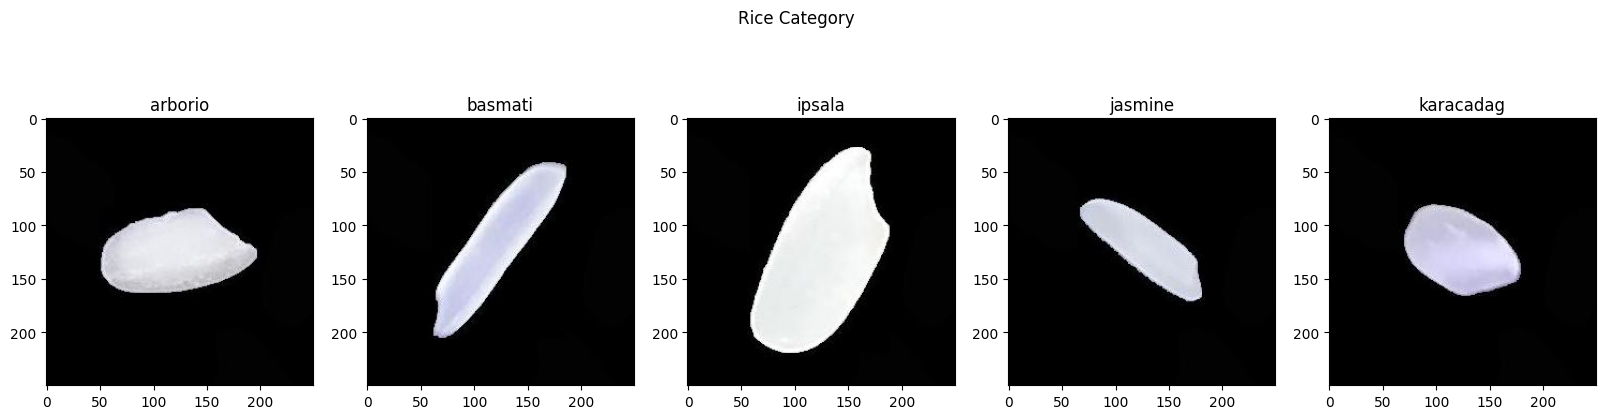

In [4]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')


ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

In [5]:
# Dict for images path
dict_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Dict for labels
dict_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

Now, it's important to know the input shape to build a model. In particular, we'll build:

* CNN;
* Transfer learning with ResNet.

In [6]:
img = cv2.imread(str(dict_images['arborio'][0]))
img.shape

(250, 250, 3)

The shape is 250x250x3 (RGB)

In [7]:
# X = images, y = labels
X, y = [], []
for label, images in dict_images.items():
    for image in images:
        img = cv2.imread(str(image))
        X.append(img)
        y.append(dict_labels[label])

In [8]:
X = np.array(X)

# Feature scaling
X = X/255

y = np.array(y)

In [9]:
# Dataset splitting
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.6, shuffle=True, stratify=y_test_val, random_state=42)

## Modeling

In [22]:
model_1 = Sequential()


## 16x16 convolution with 2x2 stride and 64 filters
model_1.add(Conv2D(64, (16, 16), strides = (2,2),
                 input_shape=X_train.shape[1:]))
model_1.add(Activation('relu'))

## 8x8 convolution with 32 filters
model_1.add(Conv2D(32, (8, 8)))
model_1.add(Activation('relu'))

## 5x5 convolution with 2x2 stride and 16 filters
model_1.add(Conv2D(16, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 5x5 max pooling with strides 2x2
model_1.add(MaxPooling2D(pool_size=(5, 5), padding='valid', strides=(2,2)))

## 5x5 convolution with 2x2 stride and 8 filters
model_1.add(Conv2D(8, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 5x5 max pooling
model_1.add(MaxPooling2D(pool_size=(5, 5), padding='valid', strides=(2,2)))
model_1.add(Dropout(0.25))

## Flatten turns 4x4x16 into 256x1
model_1.add(Flatten())
model_1.add(Dense(32))
model_1.add(Activation('relu'))
model_1.add(Dense(5))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 118, 64)      49216     
                                                                 
 activation_6 (Activation)   (None, 118, 118, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 111, 111, 32)      131104    
                                                                 
 activation_7 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 54, 54, 16)        12816     
                                                                 
 activation_8 (Activation)   (None, 54, 54, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 16)       

Third model structure: ResNet-50

In [26]:
resnet_model = Sequential()

pretrained_model = tensorflow.keras.applications.ResNet50(include_top=False,
                                                          input_shape=(250,250,3),
                                                          pooling='avg',
                                                          classes=5,
                                                          weights='imagenet')
for layer in pretrained_model.layers:
  layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [29]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 24703109 (94.23 MB)
Trainable params: 1115397 (4.25 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Models training

Note that I don't focus on search best models parameters, but comparison them with the same batch_size, epochs and optimizer, but as future you can try to optimize them.

In [24]:
batch_size = 16
epochs=20

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0005)

# Let's train the model using Adam
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

cnn_history = model_1.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val),
              shuffle=True)

Epoch 1/20
44/44 [==============================] - 5s 63ms/step - loss: 1.6174 - accuracy: 0.2071 - val_loss: 1.5909 - val_accuracy: 0.2056
Epoch 2/20
44/44 [==============================] - 2s 46ms/step - loss: 1.5708 - accuracy: 0.2343 - val_loss: 1.5233 - val_accuracy: 0.3056
Epoch 3/20
44/44 [==============================] - 2s 45ms/step - loss: 1.4425 - accuracy: 0.3586 - val_loss: 1.2934 - val_accuracy: 0.4167
Epoch 4/20
44/44 [==============================] - 2s 49ms/step - loss: 1.2528 - accuracy: 0.4586 - val_loss: 1.0371 - val_accuracy: 0.5889
Epoch 5/20
44/44 [==============================] - 2s 49ms/step - loss: 1.0777 - accuracy: 0.5529 - val_loss: 0.9078 - val_accuracy: 0.6611
Epoch 6/20
44/44 [==============================] - 2s 49ms/step - loss: 0.9989 - accuracy: 0.5743 - val_loss: 0.7860 - val_accuracy: 0.7222
Epoch 7/20
44/44 [==============================] - 2s 49ms/step - loss: 0.9110 - accuracy: 0.6329 - val_loss: 0.7333 - val_accuracy: 0.7667
Epoch 8/20
44

In [27]:
batch_size = 16
epochs=20
# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0005)

# Let's train the model using Adam
resnet_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

resnet_history = resnet_model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val),
              shuffle=True)

Epoch 1/20
44/44 [==============================] - 9s 127ms/step - loss: 1.3874 - accuracy: 0.4043 - val_loss: 1.1144 - val_accuracy: 0.4833
Epoch 2/20
44/44 [==============================] - 4s 94ms/step - loss: 1.0051 - accuracy: 0.5686 - val_loss: 0.8956 - val_accuracy: 0.6389
Epoch 3/20
44/44 [==============================] - 3s 79ms/step - loss: 0.7768 - accuracy: 0.6743 - val_loss: 0.6750 - val_accuracy: 0.7222
Epoch 4/20
44/44 [==============================] - 4s 94ms/step - loss: 0.6730 - accuracy: 0.7114 - val_loss: 0.5662 - val_accuracy: 0.8167
Epoch 5/20
44/44 [==============================] - 4s 82ms/step - loss: 0.5276 - accuracy: 0.8243 - val_loss: 0.4652 - val_accuracy: 0.8889
Epoch 6/20
44/44 [==============================] - 4s 81ms/step - loss: 0.4882 - accuracy: 0.8143 - val_loss: 0.4261 - val_accuracy: 0.8556
Epoch 7/20
44/44 [==============================] - 4s 81ms/step - loss: 0.4765 - accuracy: 0.8014 - val_loss: 0.4130 - val_accuracy: 0.8167
Epoch 8/20
4

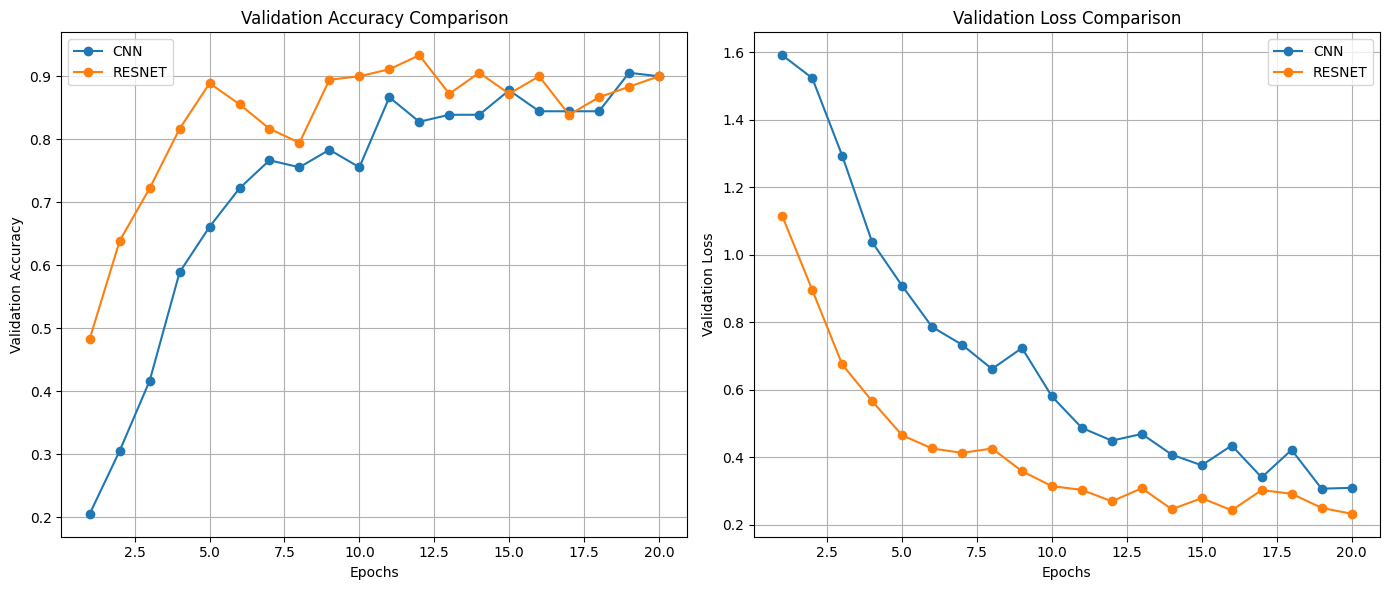

In [28]:
acc_model_1 = cnn_history.history['val_accuracy']
loss_model_1 = cnn_history.history['val_loss']

acc_model_2 = resnet_history.history['val_accuracy']
loss_model_2 = resnet_history.history['val_loss']

# Estrai le epoche
epochs = range(1, len(acc_model_1) + 1)

# Crea i grafici affiancati
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Grafico per le accuracy
axes[0].plot(epochs, acc_model_1, label='CNN', marker='o')
axes[0].plot(epochs, acc_model_2, label='RESNET', marker='o')
axes[0].set_title('Validation Accuracy Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Validation Accuracy')
axes[0].legend()
axes[0].grid(True)

# Grafico per le loss
axes[1].plot(epochs, loss_model_1, label='CNN', marker='o')
axes[1].plot(epochs, loss_model_2, label='RESNET', marker='o')
axes[1].set_title('Validation Loss Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()
axes[1].grid(True)

# Regola la disposizione
plt.tight_layout()

# Mostra i grafici
plt.show()


Saving models

In [16]:
model_1.save('/content/cnn.h5')
resnet_model.save('/content/resnet.h5')

## Evaluation

In [17]:
model_1.evaluate(X_test,y_test)

4/4 [==============================] - 2s 323ms/step - loss: 0.2795 - accuracy: 0.9000


[0.2794772982597351, 0.8999999761581421]

In [18]:
resnet_model.evaluate(X_test,y_test)

4/4 [==============================] - 5s 723ms/step - loss: 0.2772 - accuracy: 0.9167


[0.27718955278396606, 0.9166666865348816]

In [19]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2/2 [==============================] - 5s 2s/step
              precision    recall  f1-score   support

           0       0.89      0.71      0.79        24
           1       0.92      0.96      0.94        24
           2       1.00      0.96      0.98        24
           3       0.88      0.88      0.88        24
           4       0.83      1.00      0.91        24

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [20]:
from sklearn.metrics import classification_report

y_pred = resnet_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

2/2 [==============================] - 9s 4s/step
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        24
           1       0.92      0.96      0.94        24
           2       0.96      1.00      0.98        24
           3       0.90      0.75      0.82        24
           4       1.00      0.92      0.96        24

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120



By adopting the transfer learning technique with ResNet as a base, we achieved slightly better performance compared to the CNN built from scratch. Although the performance is better, it's worth noting that the model built from scratch has significantly fewer parameters (200K) compared to ResNet (over 24 million, with only about one million fine-tuned). This suggests that finding the right trade-off between complexity and performance is crucial. As future steps, one can consider enhancing the model built from scratch, optimizing hyperparameters, or evaluating the same models on a larger portion of the dataset.

That's all, see you!